# Finding pairs and tiles of EMIT/S2

## Dependencies

In [1]:
!pip install -q numpy xarray rasterio shapely pyproj matplotlib panel holoviews hvplot tqdm jupyter_bokeh pystac-client earthaccess netCDF4 spectral rioxarray hvplot
!pip install -q "git+https://github.com/EnSpec/hytools.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2

In [2]:
!git clone https://github.com/martasumyk/hyperspectral_super-resolution

Cloning into 'hyperspectral_super-resolution'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 142 (delta 76), reused 84 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 2.94 MiB | 4.46 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [3]:
%cd /content/hyperspectral_super-resolution/

/content/hyperspectral_super-resolution


In [4]:
!apt-get update
!apt-get install -y gdal-bin

!gdalwarp --version

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,201 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,842 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-se

In [ ]:
import os, json, math
from pathlib import Path
from datetime import datetime, date, timezone, timedelta
from datetime import timezone
from pprint import pprint
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from rasterio.windows import Window, transform as win_transform



import numpy as np
import json
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from tqdm import tqdm

import panel as pn
import holoviews as hv
import hvplot.xarray

from pystac_client import Client

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from EMIT_data.emit_tools import emit_xarray
from s2_data.s2_utils import plot_s2_truecolor

from s2_data.s2_utils import (
    point_buffer_bbox, get_item_dt_utc, download_asset, plot_s2_truecolor, find_best_s2_for_date
)
from s2_data.cloud_utils import (
    find_asset_key, reproject_geom, scl_metrics, count_cloud_pixels
)

from EMIT_data.EMIT_utils import (
    login, search, download_reflectance, open_reflectance, attach_wavelengths
)
from EMIT_data.emit_tools import quality_mask, band_mask
from EMIT_data.emit_proj import nc_to_envi
from EMIT_data.viz import show_emit_rgb_from_envi

pn.extension("tabulator")
hv.extension("bokeh")


## Earthdata login

Login to https://urs.earthdata.nasa.gov/.

In [6]:
login(persist=True)

Enter your Earthdata Login username: martasumyk
Enter your Earthdata password: ··········


## Parameters

In [7]:
LAT = 20
LON = 35

SEARCH_BUFFER_M = 20_000  # meters radius around point

In [8]:
S2_API = "https://earth-search.aws.element84.com/v1"
S2_COLLECTION = "sentinel-2-l2a"

Date window:

In [9]:
from datetime import date
DATE_START = date(2022, 1, 1)
DATE_END = date.today()

Cloud thresholds:

In [10]:
MAX_S2_CLOUD_FRAC = 50.0
MAX_EMIT_CLOUD_PCT = 50.0

Output folders:

In [11]:
ROOT = Path("pairs_output")
EMIT_DIR = ROOT / "emit"
S2_DIR   = ROOT / "s2"
ENVI_DIR = ROOT / "envi"
FIG_DIR  = ROOT / "figures"
for p in (EMIT_DIR, S2_DIR, ENVI_DIR, FIG_DIR):
    p.mkdir(parents=True, exist_ok=True)


## Helpers

In [12]:
def _emit_item_date(item) -> date:
    """Extract UTC date from an EMIT search item."""
    try:
        iso = item["umm"]["ProviderDates"][0]["Date"]
    except Exception:
        iso = item.get("datetime") or item.get("start_time")
    dt_utc = datetime.fromisoformat(str(iso).replace("Z", "+00:00")).astimezone(timezone.utc)
    return dt_utc.date()

def _emit_cloud_pct(item) -> float:
    try:
        return float(item["umm"].get("CloudCover"))
    except Exception:
        return float("inf")

def find_emit_candidates(lon: float, lat: float):
    """Search EMIT around the location and within DATE_START..DATE_END."""
    login(persist=True)
    roi_bbox = point_buffer_bbox(lon, lat, SEARCH_BUFFER_M)
    items = search(
        point=(lon, lat),
        bbox=roi_bbox,
        start=DATE_START.isoformat(),
        end=DATE_END.isoformat(),
    )
    return list(items)

def choose_best_emit_per_date(items):
    """Group by date and keep least-cloudy EMIT per date; apply optional max cloud threshold."""
    by_date = {}
    for it in items:
        d = _emit_item_date(it)
        cur = by_date.get(d)
        if cur is None or _emit_cloud_pct(it) < _emit_cloud_pct(cur):
            by_date[d] = it
    if MAX_EMIT_CLOUD_PCT is not None:
        by_date = {d: it for d, it in by_date.items() if _emit_cloud_pct(it) <= MAX_EMIT_CLOUD_PCT}
    return {d.isoformat(): it for d, it in by_date.items()}


def download_s2_truecolor(item) -> Path:
    """Download S2 visual (true color) if available; else save B04/B03/B02 and return JSON list."""
    assets = item.assets
    if "visual" in assets:
        href = assets["visual"].href
        out = S2_DIR / f"{item.id}_visual.tif"
        if not out.exists():
            download_asset(href, out)
        return out
    band_paths = []
    for b in ("B04", "B03", "B02"):
        if b in assets:
            href = assets[b].href
            out = S2_DIR / f"{item.id}_{b}.tif"
            if not out.exists():
                download_asset(href, out)
            band_paths.append(str(out))
    out_json = S2_DIR / f"{item.id}_RGB_bands.json"
    out_json.write_text(json.dumps(band_paths, indent=2))
    return out_json


def convert_emit_nc_to_envi(emit_nc_paths, s2_visual_path, out_dir, emit_obs_nc=None) -> Path:
    """
    Run nc_to_envi and return the path to the RFL ENVI .bin cube.

    emit_nc_paths : list[Path] or similar from download_reflectance
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    tmp_dir = out_dir / "tmp"
    tmp_dir.mkdir(parents=True, exist_ok=True)

    print(emit_nc_paths[0])
    nc_to_envi(
        img_file=str(emit_nc_paths[0]),
        out_dir=str(out_dir),
        temp_dir=str(tmp_dir),
        obs_file=str(emit_obs_nc) if emit_obs_nc else None,
        export_loc=True,
        crid="000",
        s2_tif_path=str(s2_visual_path),
        match_res=False,
        write_xml=False,
    )

    # hytools usually writes into out_dir / "emit_out"
    emit_out = out_dir / "emit_out"
    search_root = emit_out if emit_out.exists() else out_dir

    # Look for the reflectance cube
    for pattern in ("*RFL*000.bin", "*RFL*.bin", "*.bin"):
        bins = sorted(search_root.glob(pattern))
        if bins:
            print("Picked ENVI cube:", bins[0])
            return bins[0]

    raise FileNotFoundError(f"ENVI .bin not found under {search_root}")



def visualize_pair(date_iso: str, s2_path: Path, envi_bin_path: Path) -> Path:
    fig = plt.figure(figsize=(12, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    # --- S2 side ---
    try:
        # s2_path can be a visual.tif or a JSON with band paths
        if isinstance(s2_path, Path) and s2_path.suffix.lower() == ".json":
            s2_paths = json.loads(s2_path.read_text())
        else:
            s2_paths = [str(s2_path)]

        plot_s2_truecolor(s2_paths, ax=ax1)
    except Exception as e:
        ax1.text(0.5, 0.5, f"S2 plot failed: {e}", ha="center", va="center")
        ax1.set_axis_off()

    # --- EMIT side ---
    try:
        show_emit_rgb_from_envi_ax(envi_bin_path, ax=ax2, gamma=1.0)
    except Exception as e:
        ax2.text(0.5, 0.5, f"EMIT plot failed: {e}", ha="center", va="center")
        ax2.set_axis_off()

    out_png = FIG_DIR / f"pair_{date_iso}.png"
    fig.tight_layout()
    fig.savefig(out_png, dpi=150)
    plt.close(fig)
    return out_png



## Inference (finding cloud-free pairs)

In [13]:
roi_bbox = point_buffer_bbox(LON, LAT, SEARCH_BUFFER_M)
print("ROI BBOX:", roi_bbox)

ROI BBOX: POLYGON ((35.190901311226696 19.81923404729812, 35.19133739123764 20.180556162375762, 34.808662608762354 20.180556162375762, 34.809098688773304 19.81923404729812, 35.190901311226696 19.81923404729812))


In [14]:
picks = search(point=(LON, LAT), bbox = roi_bbox.bounds, buffer_m=SEARCH_BUFFER_M, start=None, end=None, cloud_cover = (0.0,100.0))
emit_by_date = choose_best_emit_per_date(picks)
print(f"Found {len(emit_by_date)} EMIT dates")

Found 26 granule(s).
Found 13 EMIT dates


In [15]:
pairs = []
for d_iso, emit_item in emit_by_date.items():
    s2_item, s2_cloud = find_best_s2_for_date(d_iso, LON, LAT, S2_COLLECTION, SEARCH_BUFFER_M, S2_API, S2_DIR)
    if s2_item is None:
        continue
    if (s2_cloud is None) or (s2_cloud > MAX_S2_CLOUD_FRAC):
        continue
    pairs.append({
        "date": d_iso,
        "emit": emit_item,
        "emit_cloud_pct": _emit_cloud_pct(emit_item),
        "s2": s2_item,
        "s2_cloud_frac": s2_cloud,
    })

print(f"Kept {len(pairs)} EMIT/S2 same-day pairs after cloud filtering.")

S2 cloud check 2023-01-27:   0%|          | 0/4 [00:00<?, ?it/s]
S2A_36QXG_20230127_0_L2A_SCL.tif:   0%|          | 0.00/236k [00:00<?, ?B/s]
S2A_36QXG_20230127_0_L2A_SCL.tif: 100%|██████████| 236k/236k [00:00<00:00, 625kB/s]
S2 cloud check 2023-01-27:  25%|██▌       | 1/4 [00:01<00:03,  1.19s/it]
S2A_36QYG_20230127_0_L2A_SCL.tif:   0%|          | 0.00/363k [00:00<?, ?B/s]
S2A_36QYG_20230127_0_L2A_SCL.tif: 100%|██████████| 363k/363k [00:00<00:00, 726kB/s]
S2 cloud check 2023-01-27:  50%|█████     | 2/4 [00:02<00:02,  1.09s/it]
S2A_36QXH_20230127_0_L2A_SCL.tif:   0%|          | 0.00/299k [00:00<?, ?B/s]
S2A_36QXH_20230127_0_L2A_SCL.tif: 100%|██████████| 299k/299k [00:00<00:00, 779kB/s]
S2 cloud check 2023-01-27:  75%|███████▌  | 3/4 [00:03<00:01,  1.01s/it]
S2A_36QYH_20230127_0_L2A_SCL.tif:   0%|          | 0.00/409k [00:00<?, ?B/s]
S2A_36QYH_20230127_0_L2A_SCL.tif: 100%|██████████| 409k/409k [00:00<00:00, 815kB/s]
S2 cloud check 2023-09-04:   0%|          | 0/4 [00:00<?, ?it/s]
S2A_36Q

Kept 2 EMIT/S2 same-day pairs after cloud filtering.


## Plot one pair

Just one pair:

In [18]:
pair = pairs[0]
emit_item = pair["emit"]
s2_item   = pair["s2"]
print(pair["date"], pair["emit_cloud_pct"], pair["s2_cloud_frac"])

2023-01-27 12.0 0.0


In [19]:
from pathlib import Path

emit_paths = download_reflectance(emit_item, str(EMIT_DIR), assets=["_RFL_"])
emit_nc = Path(emit_paths[0])
print("EMIT file:", emit_nc)


Filtered to 1 reflectance-related asset link(s).


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

EMIT file: pairs_output/emit/EMIT_L2A_RFL_001_20220816T132400_2222809_026.nc


In [20]:
s2_tif = download_s2_truecolor(s2_item)
print("S2 file:", s2_tif)

S2A_36QXG_20230127_0_L2A_visual.tif: 100%|██████████| 227M/227M [00:09<00:00, 22.9MB/s]

S2 file: pairs_output/s2/S2A_36QXG_20230127_0_L2A_visual.tif


In [21]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio



def _nearest_band_indices(wavelengths, targets_nm):
    """Return indices in `wavelengths` nearest to each nm in `targets_nm`."""
    wl = np.asarray(wavelengths, dtype=float)
    idxs, picked = [], []
    for t in targets_nm:
        i = int(np.argmin(np.abs(wl - float(t))))
        idxs.append(i)
        picked.append(wl[i])
        print(f"Picked band {i} at {wl[i]:.1f} nm for target {t:.1f} nm")
    return idxs, picked

def _percentile_stretch(img, p_low=2, p_high=98):
    """Apply per-channel percentile stretch to 0..1."""
    img = img.astype(np.float32)
    out = np.zeros_like(img, dtype=np.float32)
    if img.ndim == 3:
        for c in range(3):
            ch = img[..., c]
            finite = np.isfinite(ch)
            if not np.any(finite):
                continue
            lo, hi = np.percentile(ch[finite], (p_low, p_high))
            if hi <= lo:
                continue
            out[..., c] = np.clip((ch - lo) / (hi - lo), 0, 1)
    else:
        finite = np.isfinite(img)
        if np.any(finite):
            lo, hi = np.percentile(img[finite], (p_low, p_high))
            if hi > lo:
                out = np.clip((img - lo) / (hi - lo), 0, 1)
    return out

def _parse_wavelengths_from_tags(tags: dict):
    """
    ENVI stores wavelengths as a header key like:
      'wavelength': '{ 400.0, 401.0, ... }'
    This parses it into a list[float]. Returns None if absent.
    """
    w_txt = tags.get('wavelength') or tags.get('WAVELENGTH')
    if not w_txt:
        return None
    # normalize to Python list literal
    w_txt = w_txt.strip()
    if w_txt.startswith('{') and w_txt.endswith('}'):
        w_txt = '[' + w_txt[1:-1] + ']'
    # remove potential line breaks, duplicate spaces
    w_txt = re.sub(r'\s+', ' ', w_txt)
    try:
        vals = ast.literal_eval(w_txt)
        return [float(v) for v in vals]
    except Exception:
        return None


def show_emit_rgb_from_envi(out_dir,
                            pattern="SISTER_EMIT_L2A_RFL_*_000.bin",
                            targets_nm=(630.0, 532.0, 465.0),
                            percentile=(2, 98),
                            gamma=1/2.2,
                            white_balance=True,
                            ax=None):
    """
    Find the EMIT RFL ENVI output in out_dir and display an RGB.

    If `ax` is provided, the image is drawn on that axes (e.g. for subplots).
    If `ax` is None, a new figure and axes are created.
    """
    # 1) pick file
    bins = sorted(glob.glob(os.path.join(out_dir, pattern)))
    if not bins:
        raise FileNotFoundError(f"No files matching {pattern} in {out_dir}")
    data_bin = bins[-1]  # latest
    print(f"Reading: {os.path.basename(data_bin)}")

    # 2) open with rasterio, read metadata + bands
    with rasterio.open(data_bin) as ds:
        # wavelengths from header tags (file-level)
        tags = ds.tags()
        wavelengths = _parse_wavelengths_from_tags(tags)
        if wavelengths is None:
            # sometimes wavelengths end up as per-band tags; try that
            wavelengths = []
            for b in range(1, ds.count+1):
                bt = ds.tags(b)
                w = bt.get('wavelength') or bt.get('WAVELENGTH')
                wavelengths.append(float(w) if w else np.nan)
            if not np.isfinite(wavelengths).any():
                raise ValueError("No wavelengths found in ENVI header tags.")

        idxs, picked = _nearest_band_indices(wavelengths, targets_nm)
        # rasterio bands are 1-based
        R = ds.read(idxs[0] + 1).astype(np.float32)
        G = ds.read(idxs[1] + 1).astype(np.float32)
        B = ds.read(idxs[2] + 1).astype(np.float32)

        # 3) handle nodata and reflectance scaling (EMIT reflectance should be 0..1)
        nodata = ds.nodata
        if nodata is not None:
            for arr in (R, G, B):
                arr[arr == nodata] = np.nan

        # clip extreme outliers (safety), then percentile-stretch
        rgb = np.dstack([np.clip(R, 0, 1),
                         np.clip(G, 0, 1),
                         np.clip(B, 0, 1)])

        rgb = _percentile_stretch(rgb, *percentile)

        if white_balance:
            means = np.nanmean(rgb.reshape(-1, 3), axis=0)
            scale = np.nanmean(means) / np.maximum(means, 1e-6)
            rgb = np.clip(rgb * scale, 0, 1)

        rgb_disp = np.clip(rgb, 0, 1) ** gamma

        # 4) plot
        created_fig = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
            created_fig = True

        ax.imshow(rgb_disp, origin="upper")
        epsg = ds.crs.to_string() if ds.crs else "unknown CRS"
        ax.set_title(f"EMIT True Color ~ {picked[0]:.0f}/{picked[1]:.0f}/{picked[2]:.0f} nm\n{epsg}")
        ax.axis("off")

        if created_fig:
            plt.show()


pairs_output/emit/EMIT_L2A_RFL_001_20220816T132400_2222809_026.nc
pairs_output/emit/EMIT_L2A_RFL_001_20220816T132400_2222809_026.nc
Opened EMIT image dataset: pairs_output/emit/EMIT_L2A_RFL_001_20220816T132400_2222809_026.nc
Disabling auto mask/scale for variable 'reflectance'
Exporting EMIT L2A_RFL dataset
Projecting data to EPSG:32636 (60 m)
Exporting EMIT location dataset
Projecting location datacube to EPSG:32636 (60 m)
Picked ENVI cube: pairs_output/emit/SISTER_EMIT_L2A_RFL_20220816T132400_000.bin
Reading: SISTER_EMIT_L2A_RFL_20220816T132400_000.bin
Picked band 33 at 626.4 nm for target 630.0 nm
Picked band 20 at 529.5 nm for target 532.0 nm
Picked band 11 at 462.6 nm for target 465.0 nm


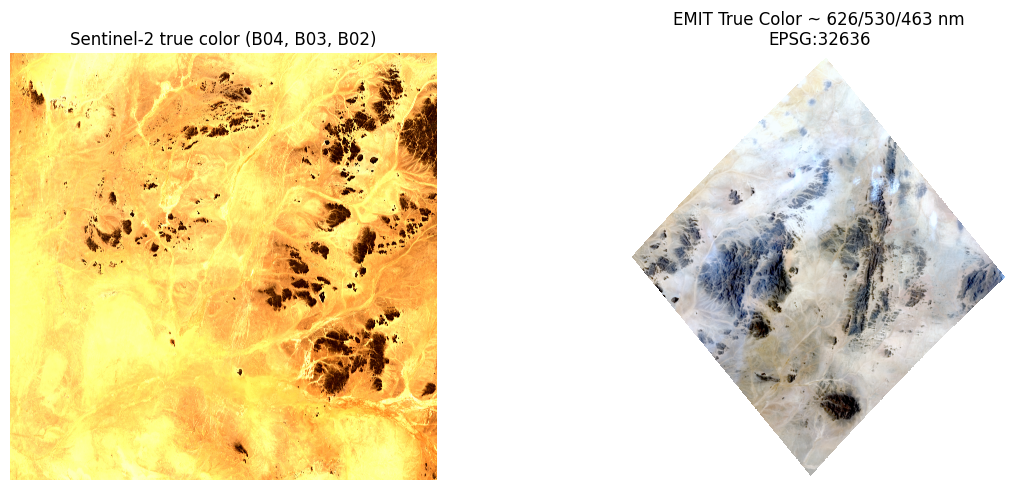

In [22]:
pair = pairs[0]

# # download EMIT reflectance
# emit_paths = download_reflectance(pair["emit"], str(EMIT_DIR), assets=["_RFL_"])
# emit_nc = emit_paths[0]
# print("Emit file:", emit_nc)

# # download S2 visual/truecolor
# s2_tif = download_s2_truecolor(pair["s2"])
# print("S2 file:", s2_tif)

if isinstance(s2_tif, Path) and s2_tif.suffix.lower() == ".tif":
        out_dir = ROOT / f"emit"
        envi_bin = convert_emit_nc_to_envi(emit_paths, s2_tif, out_dir)
else:
    out_dir = ENVI_DIR / f"emit_{d_iso}"
    out_dir.mkdir(parents=True, exist_ok=True)
    envi_bin = None

# plot
fig = plt.figure(figsize=(13, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_s2_truecolor([str(s2_tif)], ax=ax1)
path_new = "/content/hyperspectral_super-resolution/" + str(envi_bin)
show_emit_rgb_from_envi(out_dir, pattern=path_new, ax=ax2, gamma=1/2.2)

plt.tight_layout()
plt.show()


In [23]:
import rasterio
from rasterio.warp import transform
from pyproj import CRS

def print_raster_geometry(name, path):
    with rasterio.open(path) as ds:
        b = ds.bounds
        crs = ds.crs
        transform_aff = ds.transform

        # Corners in raster CRS (UTM for S2 & EMIT)
        corners_utm = {
            "UL": (b.left,  b.top),     # upper-left
            "UR": (b.right, b.top),     # upper-right
            "LR": (b.right, b.bottom),  # lower-right
            "LL": (b.left,  b.bottom)   # lower-left
        }

        # Center in raster CRS
        center_utm = ((b.left + b.right) / 2, (b.top + b.bottom) / 2)

        # Convert to WGS84
        xs = [p[0] for p in corners_utm.values()] + [center_utm[0]]
        ys = [p[1] for p in corners_utm.values()] + [center_utm[1]]

        lon, lat = transform(crs, CRS.from_epsg(4326), xs, ys)
        corners_wgs84 = {k: (lon[i], lat[i]) for i, k in enumerate(corners_utm.keys())}
        center_wgs84 = (lon[-1], lat[-1])

    print(f"\n==============================")
    print(f"{name} — Geometry")
    print(f"File: {path}")
    print(f"CRS:  {crs}")
    print("------------------------------")

    print("Corners (UTM):")
    for k, v in corners_utm.items():
        print(f"  {k}: {v}")

    print("\nCorners (WGS84):")
    for k, v in corners_wgs84.items():
        print(f"  {k}: (lon={v[0]:.6f}, lat={v[1]:.6f})")

    print("\nCenter (UTM):", center_utm)
    print("Center (WGS84): (lon=%.6f, lat=%.6f)" % center_wgs84)
    print("==============================\n")


# 🔹 Print S2 tile geometry
print_raster_geometry("SENTINEL-2", s2_tif)

# 🔹 Print EMIT tile geometry
print_raster_geometry("EMIT", envi_bin)



SENTINEL-2 — Geometry
File: pairs_output/s2/S2A_36QXG_20230127_0_L2A_visual.tif
CRS:  EPSG:32636
------------------------------
Corners (UTM):
  UL: (600000.0, 2200020.0)
  UR: (709800.0, 2200020.0)
  LR: (709800.0, 2090220.0)
  LL: (600000.0, 2090220.0)

Corners (WGS84):
  UL: (lon=33.955302, lat=19.893863)
  UR: (lon=35.003870, lat=19.885147)
  LR: (lon=34.991768, lat=18.893458)
  LL: (lon=33.949529, lat=18.901707)

Center (UTM): (654900.0, 2145120.0)
Center (WGS84): (lon=34.475117, lat=19.394309)


EMIT — Geometry
File: pairs_output/emit/SISTER_EMIT_L2A_RFL_20220816T132400_000.bin
CRS:  EPSG:32636
------------------------------
Corners (UTM):
  UL: (680143.181735713, 2243271.90388241)
  UR: (789703.181735713, 2243271.90388241)
  LR: (789703.181735713, 2120751.90388241)
  LL: (680143.181735713, 2120751.90388241)

Corners (WGS84):
  UL: (lon=34.724982, lat=20.278782)
  UR: (lon=35.773339, lat=20.265320)
  LR: (lon=35.754323, lat=19.159404)
  LL: (lon=34.713143, lat=19.172074)

Center

In [24]:
import rasterio
from rasterio.windows import from_bounds, transform as win_transform

def crop_to_overlap(s2_path, emit_path, out_s2_path, out_emit_path):
    # Open both rasters
    with rasterio.open(s2_path) as s2_ds, rasterio.open(emit_path) as emit_ds:
        # 1) Check CRS
        if s2_ds.crs != emit_ds.crs:
            raise ValueError(f"CRS mismatch: {s2_ds.crs} != {emit_ds.crs}. Reproject first.")

        # 2) Overlap in UTM
        s2_b = s2_ds.bounds
        e_b  = emit_ds.bounds

        left   = max(s2_b.left,   e_b.left)
        right  = min(s2_b.right,  e_b.right)
        bottom = max(s2_b.bottom, e_b.bottom)
        top    = min(s2_b.top,    e_b.top)

        if not (left < right and bottom < top):
            raise ValueError("No overlap between S2 and EMIT extents.")

        overlap_bounds = (left, bottom, right, top)
        print("Overlap bounds (UTM):", overlap_bounds)

        # 3) Windows
        s2_win   = from_bounds(*overlap_bounds, transform=s2_ds.transform)
        emit_win = from_bounds(*overlap_bounds, transform=emit_ds.transform)

        # 4) Read cropped data
        s2_data   = s2_ds.read(window=s2_win)
        emit_data = emit_ds.read(window=emit_win)

        # 5) Profiles
        s2_profile = s2_ds.profile.copy()
        s2_profile.update({
            "height": s2_win.height,
            "width":  s2_win.width,
            "transform": win_transform(s2_win, s2_ds.transform),
        })

        emit_profile = emit_ds.profile.copy()
        emit_profile.update({
            "height": emit_win.height,
            "width":  emit_win.width,
            "transform": win_transform(emit_win, emit_ds.transform),
        })

        # 🔹 copy ENVI/EMIT metadata tags (including wavelengths!)
        emit_tags = emit_ds.tags()

    # 6) Write cropped rasters
    with rasterio.open(out_s2_path, "w", **s2_profile) as dst:
        dst.write(s2_data)

    with rasterio.open(out_emit_path, "w", **emit_profile) as dst:
        dst.write(emit_data)
        dst.update_tags(**emit_tags)   # <-- critical

    print("Saved:")
    print("  S2  cropped ->", out_s2_path)
    print("  EMIT cropped ->", out_emit_path)


In [25]:
import rasterio

with rasterio.open(s2_tif) as s2_ds, rasterio.open(envi_bin) as emit_ds:
    print("S2 CRS:   ", s2_ds.crs)
    print("EMIT CRS: ", emit_ds.crs)


S2 CRS:    EPSG:32636
EMIT CRS:  EPSG:32636


In [26]:
import rasterio
from rasterio.windows import from_bounds, transform as win_transform

def crop_to_overlap(s2_path, emit_path, out_s2_path, out_emit_path):
    with rasterio.open(s2_path) as s2_ds, rasterio.open(emit_path) as emit_ds:
        # 1) CRS check
        if s2_ds.crs != emit_ds.crs:
            raise ValueError(f"CRS mismatch: {s2_ds.crs} != {emit_ds.crs}. Reproject EMIT first.")

        # 2) Обчислюємо спільний прямокутник (в UTM метрах)
        s2_b = s2_ds.bounds
        e_b  = emit_ds.bounds

        left   = max(s2_b.left,   e_b.left)
        right  = min(s2_b.right,  e_b.right)
        bottom = max(s2_b.bottom, e_b.bottom)
        top    = min(s2_b.top,    e_b.top)

        if not (left < right and bottom < top):
            raise ValueError("No overlap between S2 and EMIT extents.")

        overlap_bounds = (left, bottom, right, top)
        print("Overlap bounds (UTM):", overlap_bounds)

        # 3) Вікна по цих межах
        s2_win   = from_bounds(*overlap_bounds, transform=s2_ds.transform)
        emit_win = from_bounds(*overlap_bounds, transform=emit_ds.transform)

        # 4) Читаємо дані
        s2_data   = s2_ds.read(window=s2_win)
        emit_data = emit_ds.read(window=emit_win)

        # 5) Оновлені профілі
        s2_profile = s2_ds.profile.copy()
        s2_profile.update({
            "height": s2_win.height,
            "width":  s2_win.width,
            "transform": win_transform(s2_win, s2_ds.transform),
        })

        emit_profile = emit_ds.profile.copy()
        emit_profile.update({
            "height": emit_win.height,
            "width":  emit_win.width,
            "transform": win_transform(emit_win, emit_ds.transform),
        })

        emit_tags = emit_ds.tags()

    # 6) Пишемо кропнуті файли
    with rasterio.open(out_s2_path, "w", **s2_profile) as dst:
        dst.write(s2_data)

    with rasterio.open(out_emit_path, "w", **emit_profile) as dst:
        dst.write(emit_data)
        dst.update_tags(**emit_tags)

    print("Saved:")
    print("  S2  cropped  ->", out_s2_path)
    print("  EMIT cropped ->", out_emit_path)


In [27]:
out_s2   = S2_DIR   / f"{pair['date']}_s2_overlap.tif"
out_emit = EMIT_DIR / f"{pair['date']}_emit_overlap.bin"

In [28]:
crop_to_overlap(
    s2_path=s2_tif,
    emit_path=envi_bin,
    out_s2_path=str(out_s2),
    out_emit_path=str(out_emit),
)


Overlap bounds (UTM): (680143.181735713, 2120751.90388241, 709800.0, 2200020.0)


Saved:
  S2  cropped  -> pairs_output/s2/2023-01-27_s2_overlap.tif
  EMIT cropped -> pairs_output/emit/2023-01-27_emit_overlap.bin


In [29]:
import rasterio
from rasterio.windows import from_bounds, transform as win_transform

def crop_to_overlap(s2_path, emit_path, out_s2_path, out_emit_path):
    with rasterio.open(s2_path) as s2_ds, rasterio.open(emit_path) as emit_ds:
        # 1) CRS check
        if s2_ds.crs != emit_ds.crs:
            raise ValueError(f"CRS mismatch: {s2_ds.crs} != {emit_ds.crs}. Reproject first.")

        # 2) Bounds intersection
        s2_b = s2_ds.bounds
        e_b  = emit_ds.bounds

        left   = max(s2_b.left,   e_b.left)
        right  = min(s2_b.right,  e_b.right)
        bottom = max(s2_b.bottom, e_b.bottom)
        top    = min(s2_b.top,    e_b.top)

        print("S2 bounds:  ", s2_b)
        print("EMIT bounds:", e_b)
        print("Overlap candidate:", (left, bottom, right, top))

        if not (left < right and bottom < top):
            raise ValueError("No overlap between S2 and EMIT extents.")

        overlap_bounds = (left, bottom, right, top)
        print("Overlap bounds (UTM):", overlap_bounds)

        # 3) Windows
        s2_win   = from_bounds(*overlap_bounds, transform=s2_ds.transform)
        emit_win = from_bounds(*overlap_bounds, transform=emit_ds.transform)

        # 4) Read overlap data
        s2_data   = s2_ds.read(window=s2_win)
        emit_data = emit_ds.read(window=emit_win)

        # 5) Profiles
        s2_profile = s2_ds.profile.copy()
        s2_profile.update({
            "height": s2_win.height,
            "width":  s2_win.width,
            "transform": win_transform(s2_win, s2_ds.transform),
        })

        emit_profile = emit_ds.profile.copy()
        emit_profile.update({
            "height": emit_win.height,
            "width":  emit_win.width,
            "transform": win_transform(emit_win, emit_ds.transform),
        })

        # 🔹 save EMIT tags (dataset + per-band) so wavelengths survive
        emit_ds_tags   = emit_ds.tags()
        emit_band_tags = [emit_ds.tags(i) for i in range(1, emit_ds.count + 1)]

    # 6) Write overlaps
    with rasterio.open(out_s2_path, "w", **s2_profile) as dst:
        dst.write(s2_data)

    with rasterio.open(out_emit_path, "w", **emit_profile) as dst:
        dst.write(emit_data)
        dst.update_tags(**emit_ds_tags)
        for i, bt in enumerate(emit_band_tags, start=1):
            if bt:
                dst.update_tags(i, **bt)

    print("Saved overlap:")
    print("  S2  ->", out_s2_path)
    print("  EMIT->", out_emit_path)

    return out_s2_path, out_emit_path


In [30]:
out_s2_overlap   = S2_DIR   / f"{pair['date']}_s2_overlap.tif"
out_emit_overlap = EMIT_DIR / f"{pair['date']}_emit_overlap.bin"

out_s2_overlap, out_emit_overlap = crop_to_overlap(
    s2_path=s2_tif,
    emit_path=envi_bin,
    out_s2_path=str(out_s2_overlap),
    out_emit_path=str(out_emit_overlap),
)


S2 bounds:   BoundingBox(left=600000.0, bottom=2090220.0, right=709800.0, top=2200020.0)
EMIT bounds: BoundingBox(left=680143.181735713, bottom=2120751.90388241, right=789703.181735713, top=2243271.90388241)
Overlap candidate: (680143.181735713, 2120751.90388241, 709800.0, 2200020.0)
Overlap bounds (UTM): (680143.181735713, 2120751.90388241, 709800.0, 2200020.0)


Saved overlap:
  S2  -> pairs_output/s2/2023-01-27_s2_overlap.tif
  EMIT-> pairs_output/emit/2023-01-27_emit_overlap.bin


Reading: 2023-01-27_emit_overlap.bin
Picked band 33 at 626.4 nm for target 630.0 nm
Picked band 20 at 529.5 nm for target 532.0 nm
Picked band 11 at 462.6 nm for target 465.0 nm


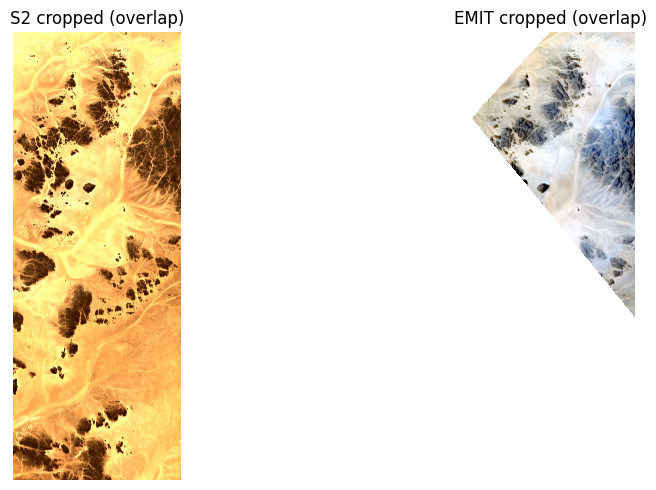

In [31]:
import matplotlib.pyplot as plt
from pathlib import Path

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 🔹 S2 cropped overlap
plot_s2_truecolor([str(out_s2_overlap)], ax=ax1)
ax1.set_title("S2 cropped (overlap)")
ax1.axis("off")

# 🔹 EMIT cropped overlap
emit_dir  = str(Path(out_emit_overlap).parent)
emit_name = Path(out_emit_overlap).name   # only filename, NOT full path

show_emit_rgb_from_envi(
    out_dir=emit_dir,
    pattern=emit_name,
    ax=ax2,
    gamma=1/2.2,
)
ax2.set_title("EMIT cropped (overlap)")
ax2.axis("off")

plt.tight_layout()
plt.show()


## Tiles

To filter out black pixels:

In [32]:
def compute_invalid_mask(tile, nodata, zero_threshold=1e-6):
    """
    tile: (bands, H, W)

    Returns mask (H, W) where pixels are considered invalid:
      - all bands ~= nodata, OR
      - all bands are very close to 0
    """
    if nodata is not None:
        is_nodata = np.all(np.isclose(tile, nodata, atol=zero_threshold), axis=0)
    else:
        is_nodata = np.zeros(tile.shape[1:], dtype=bool)

    is_zero = np.all(np.abs(tile) < zero_threshold, axis=0)
    invalid = is_nodata | is_zero
    return invalid


In [33]:
def make_paired_tiles(
    emit_path,
    s2_path,
    out_root,
    emit_tile_size=100,
    overlap_frac=0.1,
    max_invalid_frac=1,
    zero_threshold=1e-6,
):
    """
    Create paired tiles:
      - EMIT tile: emit_tile_size x emit_tile_size   (e.g. 100 x 100)
      - S2 tile:   (emit_tile_size * scale)²        (e.g. 600 x 600 if scale=6)

    overlap_frac: e.g., 0.1 -> 10% overlap → stride = 0.9 * tile size
    max_invalid_frac: max fraction of invalid (black/nodata) pixels allowed
                      separately for EMIT and S2. If either exceeds this threshold,
                      the tile is skipped.
    """
    out_root = Path(out_root)
    out_emit_dir = out_root / "emit_tiles"
    out_s2_dir   = out_root / "s2_tiles"
    out_emit_dir.mkdir(parents=True, exist_ok=True)
    out_s2_dir.mkdir(parents=True, exist_ok=True)

    with rasterio.open(emit_path) as e_ds, rasterio.open(s2_path) as s_ds:
        # --- sanity checks and scale ---
        assert e_ds.crs == s_ds.crs, "CRS mismatch between EMIT and S2"

        e_res = abs(e_ds.transform.a)  # EMIT pixel size (m)
        s_res = abs(s_ds.transform.a)  # S2 pixel size (m)

        scale_float = e_res / s_res
        scale = int(round(scale_float))
        print(f"Pixel sizes: EMIT={e_res}, S2={s_res}, scale≈{scale_float:.2f}")

        if scale <= 0 or abs(scale_float - scale) > 0.1:
            raise ValueError(
                f"EMIT/S2 resolutions not a near-integer factor (got {scale_float:.2f}). "
                "Check that EMIT is coarser than S2."
            )

        s2_tile_size = emit_tile_size * scale

        emit_stride = int(emit_tile_size * (1 - overlap_frac))
        s2_stride   = emit_stride * scale

        e_h, e_w = e_ds.height, e_ds.width
        s_h, s_w = s_ds.height, s_ds.width

        print(f"EMIT size: {e_w} x {e_h}")
        print(f"S2   size: {s_w} x {s_h}")
        print(f"Tile sizes: EMIT={emit_tile_size}, S2={s2_tile_size}")
        print(f"Strides:    EMIT={emit_stride}, S2={s2_stride}")
        print(f"max_invalid_frac={max_invalid_frac}")

        emit_nodata = e_ds.nodata
        s2_nodata   = s_ds.nodata

        emit_ds_tags   = e_ds.tags()
        emit_band_tags = [e_ds.tags(i) for i in range(1, e_ds.count + 1)]
        s2_ds_tags     = s_ds.tags()

        tile_id = 0
        kept = 0

        for er in range(0, e_h - emit_tile_size + 1, emit_stride):
            for ec in range(0, e_w - emit_tile_size + 1, emit_stride):
                sr = er * scale
                sc = ec * scale

                if sr + s2_tile_size > s_h or sc + s2_tile_size > s_w:
                    tile_id += 1
                    continue

                emit_win = Window(ec, er, emit_tile_size, emit_tile_size)
                s2_win   = Window(sc, sr, s2_tile_size, s2_tile_size)

                emit_tile = e_ds.read(window=emit_win)   # (bands, 100, 100)
                s2_tile   = s_ds.read(window=s2_win)     # (bands, 600, 600)

                inv_emit = compute_invalid_mask(emit_tile, emit_nodata, zero_threshold)
                inv_s2   = compute_invalid_mask(s2_tile, s2_nodata, zero_threshold)

                invalid_emit_frac = float(inv_emit.mean())
                invalid_s2_frac   = float(inv_s2.mean())

                if (invalid_emit_frac > max_invalid_frac) or (invalid_s2_frac > max_invalid_frac):
                    tile_id += 1
                    continue

                emit_profile = e_ds.profile.copy()
                emit_profile.update({
                    "height": emit_tile_size,
                    "width":  emit_tile_size,
                    "transform": win_transform(emit_win, e_ds.transform),
                })

                emit_fname = out_emit_dir / f"emit_tile_{tile_id:05d}.bin"
                with rasterio.open(emit_fname, "w", **emit_profile) as dst:
                    dst.write(emit_tile)
                    dst.update_tags(**emit_ds_tags)
                    for i, bt in enumerate(emit_band_tags, start=1):
                        if bt:
                            dst.update_tags(i, **bt)

                s2_profile = s_ds.profile.copy()
                s2_profile.update({
                    "height": s2_tile_size,
                    "width":  s2_tile_size,
                    "transform": win_transform(s2_win, s_ds.transform),
                })

                s2_fname = out_s2_dir / f"s2_tile_{tile_id:05d}.tif"
                with rasterio.open(s2_fname, "w", **s2_profile) as dst:
                    dst.write(s2_tile)
                    dst.update_tags(**s2_ds_tags)

                kept += 1
                tile_id += 1

        print(f"Done. Kept {kept} tiles (max_invalid_frac={max_invalid_frac}).")
        return out_emit_dir, out_s2_dir


In [34]:
emit_for_tiling = out_emit_overlap
s2_for_tiling   = out_s2_overlap

tiles_root = ROOT / "tiles"

emit_tiles_dir, s2_tiles_dir = make_paired_tiles(
    emit_path=str(emit_for_tiling),
    s2_path=str(s2_for_tiling),
    out_root=tiles_root,
    emit_tile_size=100,
    overlap_frac=0.1,     # 10% overlap
    max_invalid_frac=0.8,
)


Pixel sizes: EMIT=60.0, S2=10.0, scale≈6.00
EMIT size: 494 x 1321
S2   size: 2965 x 7926
Tile sizes: EMIT=100, S2=600
Strides:    EMIT=90, S2=540
max_invalid_frac=0.8


Done. Kept 28 tiles (max_invalid_frac=0.8).


In [35]:
import numpy as np
import rasterio
from rasterio.windows import Window
from pathlib import Path

def is_black_mask(arr, nodata=None):
    """
    arr: (bands, H, W)
    Returns a boolean (H, W) mask where pixels are 'black'.
    - If nodata is given: pixel is black if *all* bands == nodata
    - Else: pixel is black if *all* bands == 0
    """
    if nodata is not None:
        return np.all(arr == nodata, axis=0)
    else:
        return np.all(arr == 0, axis=0)


def find_valid_paired_tiles(
    emit_path,
    s2_path,
    emit_tile_size=100,
    scale=6,
    max_black_frac=0.0,
    max_tiles=None
):
    """
    Iterate over EMIT and S2 in paired tiles.
    Assumes:
      - EMIT and S2 cover the same area
      - spatial resolution ratio = `scale` (S2 is finer)
      - S2 height/width ≈ scale * EMIT height/width
    Returns a list of tile descriptors:
      [ { 'emit_window': Window, 's2_window': Window, 'idx': k }, ... ]
    """

    tiles = []

    with rasterio.open(emit_path) as emit_ds, rasterio.open(s2_path) as s2_ds:
        h_e, w_e = emit_ds.height, emit_ds.width
        h_s, w_s = s2_ds.height, s2_ds.width

        ratio_h = h_s / h_e
        ratio_w = w_s / w_e
        print(f"EMIT shape: {h_e}x{w_e}, S2 shape: {h_s}x{w_s}")
        print(f"Pixel ratio (h, w): {ratio_h:.3f}, {ratio_w:.3f}")


        emit_nodata = emit_ds.nodata
        s2_nodata = s2_ds.nodata

        tile_h_e = emit_tile_size
        tile_w_e = emit_tile_size
        tile_h_s = tile_h_e * scale
        tile_w_s = tile_w_e * scale

        idx = 0

        step_y = tile_h_e
        step_x = tile_w_e

        for row_e in range(0, h_e - tile_h_e + 1, step_y):
            for col_e in range(0, w_e - tile_w_e + 1, step_x):


                row_s = row_e * scale
                col_s = col_e * scale

                if (row_s + tile_h_s > h_s) or (col_s + tile_w_s > w_s):
                    continue

                w_emit = Window(col_e, row_e, tile_w_e, tile_h_e)
                w_s2   = Window(col_s, row_s, tile_w_s, tile_h_s)

                emit_tile = emit_ds.read(window=w_emit)
                s2_tile   = s2_ds.read(window=w_s2)

                emit_black = is_black_mask(emit_tile, nodata=emit_nodata)
                s2_black   = is_black_mask(s2_tile, nodata=s2_nodata)

                emit_black_frac = emit_black.sum() / emit_black.size
                s2_black_frac   = s2_black.sum() / s2_black.size

                if (emit_black_frac <= max_black_frac) and (s2_black_frac <= max_black_frac):
                    tiles.append(
                        {
                            "idx": idx,
                            "emit_window": w_emit,
                            "s2_window": w_s2,
                            "emit_black_frac": emit_black_frac,
                            "s2_black_frac": s2_black_frac,
                        }
                    )
                    idx += 1

                    if max_tiles is not None and len(tiles) >= max_tiles:
                        print(f"Collected {len(tiles)} tiles, stopping.")
                        return tiles

        print(f"Total valid tiles found: {len(tiles)}")
        return tiles


def save_tile_pair(emit_path, s2_path, tile_info, out_dir):
    """
    Save a single EMIT/S2 tile pair with georeferencing preserved.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    k = tile_info["idx"]

    with rasterio.open(emit_path) as emit_ds, rasterio.open(s2_path) as s2_ds:
        w_emit = tile_info["emit_window"]
        w_s2   = tile_info["s2_window"]

        emit_tile = emit_ds.read(window=w_emit)
        s2_tile   = s2_ds.read(window=w_s2)

        emit_transform = rasterio.windows.transform(w_emit, emit_ds.transform)
        s2_transform   = rasterio.windows.transform(w_s2,   s2_ds.transform)

        emit_meta = emit_ds.meta.copy()
        s2_meta   = s2_ds.meta.copy()

        emit_meta.update({
            "height": emit_tile.shape[1],
            "width":  emit_tile.shape[2],
            "transform": emit_transform,
        })
        s2_meta.update({
            "height": s2_tile.shape[1],
            "width":  s2_tile.shape[2],
            "transform": s2_transform,
        })

        emit_out = out_dir / f"tile_{k:03d}_emit.tif"
        s2_out   = out_dir / f"tile_{k:03d}_s2.tif"

        with rasterio.open(emit_out, "w", **emit_meta) as dst_e:
            dst_e.write(emit_tile)

        with rasterio.open(s2_out, "w", **s2_meta) as dst_s:
            dst_s.write(s2_tile)

    return emit_out, s2_out


In [38]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

def _percentile_stretch(img, p_low=2, p_high=98):
    img = img.astype(np.float32)
    out = np.zeros_like(img, dtype=np.float32)
    if img.ndim == 3:
        for c in range(img.shape[2]):
            ch = img[..., c]
            finite = np.isfinite(ch)
            if not np.any(finite):
                continue
            lo, hi = np.percentile(ch[finite], (p_low, p_high))
            if hi <= lo:
                continue
            out[..., c] = np.clip((ch - lo) / (hi - lo), 0, 1)
    else:
        finite = np.isfinite(img)
        if np.any(finite):
            lo, hi = np.percentile(img[finite], (p_low, p_high))
            if hi > lo:
                out = np.clip((img - lo) / (hi - lo), 0, 1)
    return out

def plot_tile_pair(emit_tile_path, s2_tile_path, title_suffix=""):
    emit_tile_path = Path(emit_tile_path)
    s2_tile_path   = Path(s2_tile_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # --- S2: RGB from first 3 bands ---
    with rasterio.open(s2_tile_path) as ds_s2:
        # shape (3, H, W)
        s2_rgb = ds_s2.read([1, 2, 3]).transpose(1, 2, 0)  # -> (H, W, 3)
        s2_rgb = _percentile_stretch(s2_rgb)
        ax1.imshow(s2_rgb)
        ax1.set_title(f"S2 tile {title_suffix}")
        ax1.axis("off")

    # --- EMIT: grayscale from one band (e.g. middle) ---
    with rasterio.open(emit_tile_path) as ds_e:
        mid_band = ds_e.count // 2 or 1
        emit_band = ds_e.read(mid_band).astype(np.float32)
        emit_band = _percentile_stretch(emit_band)
        ax2.imshow(emit_band, cmap="gray")
        ax2.set_title(f"EMIT tile {title_suffix}\n(band {mid_band})")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

In [43]:
def is_black_mask(arr, nodata=None, masked_val=-0.01,
                  nodata_atol=1e-3, zero_atol=1e-6):
    """
    arr: (bands, H, W)

    Pixel is 'black/invalid' if:
      - all bands ≈ nodata          (e.g. -9999)
      - OR all bands ≈ masked_val   (EMIT masked reflectance, ~ -0.01)
      - OR all bands ≈ 0            (true black)
    """
    if nodata is not None:
        nodata_mask = np.all(np.isclose(arr, nodata, atol=nodata_atol), axis=0)
    else:
        nodata_mask = np.zeros(arr.shape[1:], dtype=bool)

    masked_mask = np.all(np.isclose(arr, masked_val, atol=nodata_atol), axis=0)

    zero_mask = np.all(np.abs(arr) < zero_atol, axis=0)

    return nodata_mask | masked_mask | zero_mask


In [44]:
valid_tiles = find_valid_paired_tiles(
    emit_path=str(out_emit_overlap),
    s2_path=str(out_s2_overlap),
    emit_tile_size=100,
    scale=6,
    max_black_frac=0.0,
    max_tiles=2
)


EMIT shape: 1321x494, S2 shape: 7926x2965
Pixel ratio (h, w): 6.000, 6.002
Collected 2 tiles, stopping.


In [48]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path

def _stretch_01(img, p_low=2, p_high=98):
    img = img.astype(np.float32)
    finite = np.isfinite(img)
    if not np.any(finite):
        return np.zeros_like(img, dtype=np.float32)
    lo, hi = np.percentile(img[finite], (p_low, p_high))
    if hi <= lo:
        return np.zeros_like(img, dtype=np.float32)
    return np.clip((img - lo) / (hi - lo), 0, 1)

def _best_band_by_variance(ds):
    best_b, best_var = 1, -1.0
    for b in range(1, ds.count + 1):
        arr = ds.read(b).astype(np.float32)
        v = float(np.var(arr))
        if v > best_var:
            best_var = v
            best_b = b
    return best_b, best_var

In [50]:
from pathlib import Path

def plot_tile_pair_simple(emit_tile_path, s2_tile_path, title_suffix=""):
    emit_tile_path = Path(emit_tile_path)
    s2_tile_path   = Path(s2_tile_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    with rasterio.open(s2_tile_path) as ds_s2:
        rgb = ds_s2.read([1, 2, 3]).transpose(1, 2, 0).astype(np.float32)
        vmin = np.percentile(rgb, 2)
        vmax = np.percentile(rgb, 98)
        rgb = np.clip((rgb - vmin) / (vmax - vmin + 1e-6), 0, 1)
        ax1.imshow(rgb)
        ax1.set_title(f"S2 tile {title_suffix}")
        ax1.axis("off")

    with rasterio.open(emit_tile_path) as ds_e:
        best_b, best_var = 1, -1.0
        for b in range(1, ds_e.count + 1):
            arr = ds_e.read(b).astype(np.float32)
            v = float(np.var(arr))
            if v > best_var:
                best_var = v
                best_b = b

        band = ds_e.read(best_b).astype(np.float32)
        vmin = np.percentile(band, 2)
        vmax = np.percentile(band, 98)
        img = (band - vmin) / (vmax - vmin + 1e-6)
        img = np.clip(img, 0, 1) ** 0.5

        print(f"[{title_suffix}] EMIT band {best_b}, var={best_var:.3e}, "
              f"min={band.min()}, max={band.max()}")

        ax2.imshow(img, cmap="gray", vmin=0, vmax=1)
        ax2.set_title(f"EMIT tile {title_suffix}\n(best band {best_b})")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()


## Plot

[#0] EMIT band 143, var=2.044e-02, min=0.43411678075790405, max=1.3586903810501099


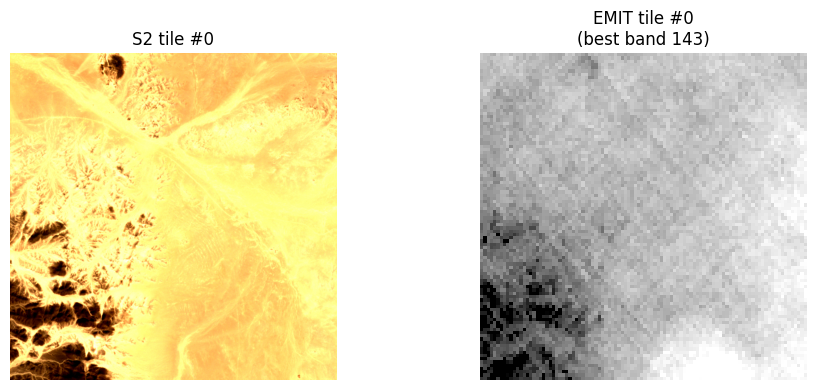

In [51]:
tiles_dir = Path("pairs_output/tiles")

plot_tile_pair_simple(
    emit_tile_path=tiles_dir / "tile_000_emit.tif",
    s2_tile_path=tiles_dir / "tile_000_s2.tif",
    title_suffix="#0",
)
